# Draft Writer Process

---

## 1. Environ Setting

In [1]:
import os
from pathlib import Path
from config.secret_keys import OPENAI_API_KEY, DART_API_KEY, TAVILY_API_KEY

os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
os.environ["DART_API_KEY"] = DART_API_KEY
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY

BASE_DIR = Path(os.getcwd())
DATA_DIR = BASE_DIR / 'data'

## 2. Import Modules

In [2]:
from langchain_openai import ChatOpenAI
from langchain.tools import tool
from langgraph.prebuilt import create_react_agent
from langchain.agents.agent_types import AgentType
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langgraph.graph import START, END, StateGraph
from langchain_community.document_loaders import WebBaseLoader
from datetime import datetime

from tavily import TavilyClient

from typing_extensions import TypedDict
from typing import List, Annotated
from pydantic import BaseModel
from operator import add

import yfinance as yf
import pandas as pd
import requests

from IPython.display import Image, display

from finpilot.test import test_app

USER_AGENT environment variable not set, consider setting it to identify your requests.


## 3. Build Application

### 3-1. Define State

In [3]:
# State
class State(TypedDict):
    messages : Annotated[List[BaseMessage], add_messages]
    question : str
    outlines : List[str]
    generation : str

### 3-2. Define Tools

#### API Clients

In [4]:
# Web Search API Client
tavily_client = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

# LLM API Client
llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)

#### fetch stock data

In [5]:
@tool
def fetch_stock_data(corp_name:str, start_date:str, end_date:str):
    """
    Use this tool when you need to fetch stock data(주식) of certain company.
    
    Args:
        corp_code (str) : comapy name (ex : '삼성전자')
        start_date (str) : start date about stock data (ex : '2024-01-01')
        end_date (str) : end date about stock data (ex : '2024-12-31')
    
    Returns:
        str : path message about saved file
    """
    def fetch_ticker_list():
        tickers = stock.get_market_ticker_list(market="ALL")

        return {
            stock.get_market_ticker_name(ticker) : ticker for ticker in tickers
        }

    def search_ticker_by_name(ticker_dict, name):
        return ticker_dict[name]
    
    ticker_dict = fetch_ticker_list()
    stock_code = search_ticker_by_name(ticker_dict, corp_name.replace(" ", ""))

    stock = yf.download(
        stock_code + '.KS', 
        start=start_date, 
        end=end_date, 
        progress=False
    )
    
    df = pd.DataFrame(index = stock.index)
    df[f'{stock_code}'] = stock['Close']
    
    csv_path = DATA_DIR / "stock_data.csv"
    df.to_csv(csv_path)

    return f"Stockfile saved to {os.path.relpath(DATA_DIR / 'stock_data.csv', os.getcwd())}"

#### fetch financial data

In [6]:
@tool
def fetch_financial_data(corp_name, report_year):
    """
    Use this tool when you need to fetch financial data (재무재표).
    
    Args:
        corp_name (str) : Company name (ex : '삼성전자')
        report_year (str) : Year that data written (ex : 2024)
    
    Returns:
        str : path message about saved file
    """

    url = f"https://opendart.fss.or.kr/api/fnlttSinglAcntAll.json"

    corp_code_df = pd.read_xml('CORPCODE.xml', encoding='utf-8')
    corp_code = corp_code_df.loc[corp_code_df['corp_name'] == corp_name.replace(" ", ""), 'corp_code'].iloc[0]
    corp_code = str(corp_code).zfill(8)

    params = {
        'crtfc_key': os.getenv('DART_API_KEY'),
        'corp_code': corp_code,
        'bsns_year': report_year,       # 사업연도
        'reprt_code': '11012',     # 보고서 코드 (반기 보고서)
        'fs_div': 'CFS'            # 재무제표 유형 ('CFS' 또는 'OFS') CFS: 연결재무제표 OFS: 재무제표 (개별)
    }

    # API 호출
    response = requests.get(url, params=params)

    # JSON 응답 확인
    if response.status_code == 200:
        data = response.json()
        if data['status'] == '000':
            df = pd.DataFrame(data['list'])
            df.to_csv(DATA_DIR / "finance_data.csv", encoding="utf-8")
            return f"finance data saved to {os.path.relpath(DATA_DIR / 'finance_data.csv', os.getcwd())}"
        else:
            return f"Cannot find Data for {corp_name}"
    else:
        return f"Fail to Call API, {response.status_code}"

#### CSV file Data Analize Tool

In [7]:
@tool
def analyze_csv_data(query : str, data_path : str):
    """
    저장된 주식 데이터와 재무 데이터를 pandas_agent로 분석하고 질문에 답변합니다.

    Args : 
        query (str) : 사용자 질문
        data_path (str) : 분석할 csv file 경로
    """

    custom_prefix = f"""
        You are very smart analyst can use given data.
        Please analyze the data in various perspective to fine valuable insight.
        You shoould always make the greatest output with accurate metrics and tables.
    """

    df_list = [pd.read_csv(data_path)]

    pandas_agent = create_pandas_dataframe_agent(
        ChatOpenAI(model="gpt-4o"),
        df_list,
        verbose=True,
        agent_type=AgentType.OPENAI_FUNCTIONS,
        allow_dangerous_code=True,
        prefix = custom_prefix # (옵션) prompt에 의도한 문장을 추가
    )

    result = pandas_agent.invoke(query)

    return result

#### fetch news data

In [8]:
@tool
def fetch_company_news(company_name: str) -> str:
    """
    Collect recent news for the given company.
    
    Args :
        company_name : Company name
    """
    search_results = tavily_client.search(query=f"recent news about {company_name}", days=7)
    return f"Collected news and market data for {company_name}: \n{search_results}"

@tool
def fetch_market_news(sector: str) -> str:
    """
    Collect recent market datafor the given company's sector.
    
    Args
        sector (str) : company's sector
    """
    search_results = tavily_client.search(query=f"{sector} industry news", days=7)
    return f"Collected news and market data for {sector}: {search_results}"

@tool
def fetch_webpages_scrape(urls: List[str]) -> str:
    """Scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
         for doc in docs]
    )

### 3-3. Define Agent

#### make outline

In [9]:
class OutlineModel(BaseModel):
    outlines : Annotated[List[str], add]


def make_outline_node(state : State):
    question = state["question"]

    outliner_llm = llm.with_structured_output(OutlineModel)

    outliner_system_prompt = """
        당신은 훌륭한 분석가 입니다. 당신은 사용자가 요청한 문서 초안에 대해 목차를 만들어야 합니다.
        이를 위해 다음의 지침에 따라 초안의 목차를 작성하세요 :

        <지침>
        1. 사용자가 요청한 문서 초안에 대해 서론-본론-결론의 흐름이 분명하도록 목차를 작성하세요. 서론, 본론, 결론 이라는 단어를 사용할 필요는 없습니다.
        2. 주식, 재무재표, 뉴스, 웹 검색 등의 데이터 수집을 통해 신빙성있는 문서를 작성할 수 있도록 목차를 작성하세요
        3. 목차는 소제목까지 포함하여 최대 10개의 목차까지만 작성하세요.
        4. 가독성을 위해 번호를 반드시 부여하세요.
        </지침>
    """

    outliner_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", outliner_system_prompt),
            ("human", """
                사용자의 요청은 다음과 같습니다. :
                <요청>
                사용자 요청 : {question}
                </요청>
                
                이에 따라 문서의 목차를 작성해주세요.
            """
            )
        ]
    )

    outliner = outliner_prompt | outliner_llm

    response = outliner.invoke({"question" : question})

    state["outlines"] = response.outlines[::-1]

    print("[Graph Log] Created outlines :")
    print(f"{state['outlines']}")

    return state

#### Write Paragraph for each outline

In [10]:
def write_draft_paragraph_node(state : State) :
    question = state["question"]
    outlines = state["outlines"]
    outline = outlines.pop()

    today = datetime.today().strftime("%Y-%m-%d")

    print(f"[Graph Log] Current Outline Title : {outline}")

    draft_prompt = f"""
        오늘은 {today} 입니다.
        당신은 훌륭한 분석가 입니다. 당신은 사용자가 요청한 문서의 초안을 작성해야합니다.
        이를 위해 다음의 지침에 따라 초안의 목차에 대한 단락을 최신 정보를 활용하여 작성하세요 :
        
        <지침>
        1. 사용자의 요청에 대해 현재 주어진 목차에 대한 단락을 작성하세요.
        2. 단락 작성 간 필요한 경우 특정 기업에 대한 '주식', '재무재표' 데이터를 수집하세요.
        3. 특정 기업에 대한 '주식', '재무재표' 데이터를 수집이 필요하지 않은 경우, 뉴스와 웹 검색 만을 사용하여 단락을 작성해세요.
        3. 단락 작성 간 충분한 근거를 제시하며 사실에 입각한 내용을 작성하세요.
        4. 형식은 마크다운, 언어는 한국어를 사용하세요.
        </지침>

        사용자 요청과 현재 작성해야할 목차는 다음과 같습니다. :
        <요청과 목차>
        사용자 요청 : {question}
        현재 목차 : {outline}
        </요청과 목차>

        주식, 재무재표 데이터를 수집하기 위해 제공한 tools를 사용하며 해당 tool을 사용하면 아래의 경로에 데이터를 저장합니다.
        해당 경로의 데이터를 활용하여 데이터를 분석하세요.
        <데이터 출처>
        주식 데이터 : {os.path.relpath(DATA_DIR / 'stock_data.csv', os.getcwd())}
        재무재표 데이터 : {os.path.relpath(DATA_DIR / 'finance_data.csv', os.getcwd())}
        </데이터 출처>
    """

    draft_writer = create_react_agent(
        model=llm,
        tools=[fetch_stock_data, fetch_financial_data, analyze_csv_data, fetch_company_news, fetch_market_news, fetch_webpages_scrape],
        state_modifier = draft_prompt
    )

    response = draft_writer.invoke(state)

    state["messages"] = response["messages"]
    state["outlines"] = outlines
    content = ("\n" + response["messages"][-1].content)
    print(f'[Graph Log] current contents : {content}')
    try :
        state["generation"] += content
    except :
        state["generation"] = content
    
    return state

#### determine should continue

In [11]:
def should_continue(state):
    outlines = state["outlines"]

    if len(outlines) == 0:
        return "end"
    else:
        return "continue"

### 3-4. Define Application

In [4]:
from finpilot.draft import DraftProcess

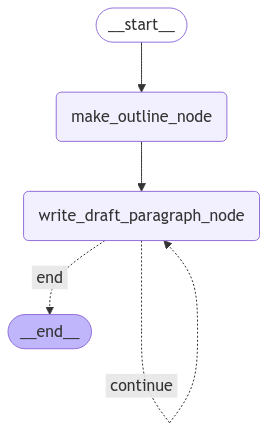

In [5]:
workflow = StateGraph(State)
draft_process = DraftProcess(data_dir=DATA_DIR)

workflow.add_node("write_draft_paragraph_node", draft_process.write_draft_paragraph_node)
workflow.add_node("make_outline_node", draft_process.make_outline_node)

workflow.add_edge(START, "make_outline_node")
workflow.add_edge("make_outline_node", "write_draft_paragraph_node")
workflow.add_conditional_edges(
    "write_draft_paragraph_node",
    draft_process.should_continue,
    {
        "end" : END,
        "continue" : "write_draft_paragraph_node"
    }
)

app = workflow.compile()

display(Image(app.get_graph().draw_mermaid_png()))

## 4. Test Application

In [6]:
test_app(app, {"question" : "삼성전자 기업분석 보고서 작성해줘"})

[Graph Log] Created outlines :
['6. 결론 및 향후 전망', '5. 최근 뉴스 및 이슈', '   4.2. 배당 정책', '   4.1. 주가 동향', '4. 주식 성과 및 투자 분석', '   3.2. 주요 재무 비율', '   3.1. 최근 3년간 재무제표 분석', '3. 재무 성과 분석', '   2.2. 스마트폰 시장 분석', '   2.1. 반도체 산업 동향', '2. 산업 현황 및 경쟁 분석', '1. 삼성전자 개요']

======================= make_outline_node =======================

State
    'messages' : 
        []
    'question' : 
        삼성전자 기업분석 보고서 작성해줘
    'outlines' : 
        ['6. 결론 및 향후 전망', '5. 최근 뉴스 및 이슈', '   4.2. 배당 정책', '   4.1. 주가 동향', '4. 주식 성과 및 투자 분석', '   3.2. 주요 재무 비율', '   3.1. 최근 3년간 재무제표 분석', '3. 재무 성과 분석', '   2.2. 스마트폰 시장 분석', '   2.1. 반도체 산업 동향', '2. 산업 현황 및 경쟁 분석', '1. 삼성전자 개요']


[Graph Log] Current Outline Title : 1. 삼성전자 개요


> Entering new AgentExecutor chain...
주어진 데이터는 2023년 초의 삼성전자 주식 가격 데이터입니다. 2024년의 주식 동향을 분석하기 위해서는 2024년의 데이터가 필요합니다. 하지만, 현재는 2024년의 데이터가 제공되지 않았습니다. 

데이터가 없는 상황에서 2024년의 동향을 예측하거나 분석하기 위해서는 다양한 방법을 사용할 수 있습니다. 예를 들어:

1. **과거 데이터의 분석**: 2023년 데이터를 기반으로 주식의 평균, 변동성, 상승 및 하락 추세를 파악할 수 있습니

In [ ]:
test_app(app, {"question" : "최근 코스피에 대한 이슈를 정리해서 시장 분석 보고서 초안을 작성해줘"})